# Generator 구성하기

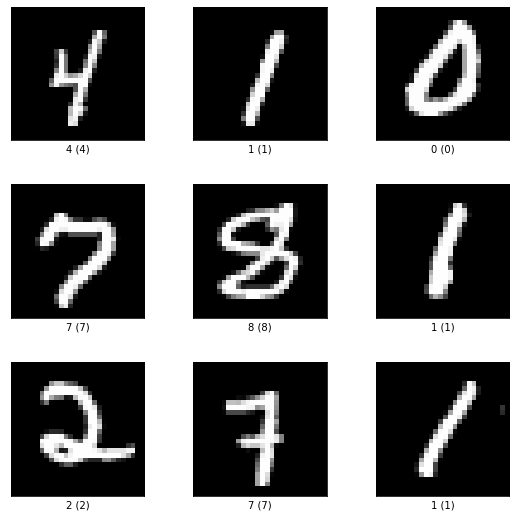

In [1]:
#MNIST DATASET 활용

import tensorflow_datasets as tfds

mnist,info = tfds.load(
"mnist",split="train",with_info=True)

fig = tfds.show_examples(mnist,info)

In [ ]:
import tensorflow as tf

BATCH_SIZE = 128

def gan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)#텐서를 새로운 형태로 캐스팅
    image = (image / 127.5) - 1
    return image
#이미지를 받아 읽어오고 0~255값인 픽셀을 -1~+1로 바꾸어주는 함수
#Generator의 output이 -1과 1사이이기 때문에

def cgan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    
    label = tf.one_hot(data["label"], 10)
    return image, label
#레이블을 원핫인코딩
# map은 입력받은 자료형의 각 요소를 함수 f가 수행한 결과를 묶어서 돌려주는 함수이다.

gan_datasets = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)
print("✅")


In [ ]:
import matplotlib.pyplot as plt

for i,j in cgan_datasets : break

# 이미지 i와 라벨 j가 일치하는지 확인해 봅니다.     
print("Label :", j[0])
print("Image Min/Max :", i.numpy().min(), i.numpy().max())
plt.imshow(i.numpy()[0,...,0], plt.cm.gray)

### GAN Generator 구성하기
이번 구현은 Tensorflow2의 Subclassing 방법을 이용하겠습니다. Subclassing 방법은 tensorflow.keras.Model 을 상속받아 클래스를 만들며, 일반적으로 __init__() 메서드 안에서 레이어 구성을 정의하고, 구성된 레이어를 call() 메서드에서 사용해 forward propagation을 진행합니다. 

In [ ]:
from tensorflow.keras import layers, Input, Model

class GeneratorGAN(Model):
    def __init__(self):
        super(GeneratorGAN, self).__init__()

        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(256, activation='relu')
        self.dense_3 = layers.Dense(512, activation='relu')
        self.dense_4 = layers.Dense(28*28*1, activation='tanh')

        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise):
        out = self.dense_1(noise)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return self.reshape(out)

print("✅")

### cGAN Generator 구성하기

In [ ]:
class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        
        self.dense_z = layers.Dense(256, activation='relu')
        self.dense_y = layers.Dense(256, activation='relu')
        self.combined_dense = layers.Dense(512, activation='relu')
        self.final_dense = layers.Dense(28 * 28 * 1, activation='tanh')
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise, label):
        noise = self.dense_z(noise)
        label = self.dense_y(label)
        out = self.combined_dense(tf.concat([noise, label], axis=-1))
        out = self.final_dense(out)
        return self.reshape(out)
    
print("✅")

# Discriminator 구성하기

In [ ]:
class DiscriminatorGAN(Model):
    def __init__(self):
        super(DiscriminatorGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.blocks = []
        for f in [512, 256, 128, 1]:
            self.blocks.append(
                layers.Dense(f, activation=None if f==1 else "relu")
            )
        
    def call(self, x):
        x = self.flatten(x)
        for block in self.blocks:
            x = block(x)
        return x
    
print("✅")

여기에서는 __init__()에 blocks라는 리스트를 하나 만들어 놓고, for loop를 이용하여 필요한 레이어들을 차곡차곡 쌓아놓았습니다. 이러한 방식을 이용하면 각각의 fully-connected 레이어를 매번 정의하지 않아도 되므로 많은 레이어가 필요할 때 편리합니다. Discriminator의 입력은 Generator가 생성한 (28,28,1) 크기의 이미지이며, 이를 fully-connected 레이어로 학습하기 위해 call()에서는 가장 먼저 layers.Flatten()이 적용됩니다. 이어서 레이어들이 쌓여있는 blocks에 대해 for loop를 이용하여 레이어들을 순서대로 하나씩 꺼내 입력 데이터를 통과시킵니다. 마지막 fully-connected 레이어를 통과하면 진짜 및 가짜 이미지를 나타내는 1개의 값이 출력됩니다.

``` 레이어를 이런 식으로 쌓는건 처음 봐서 신기하다. 리스트 안에 레이어가 들어갈 수 있음을 알았다. 차례대로 512, 256, 128, 1 사이즈의 fully connected레이어가 리스트 안에 쌓이나보다. def call 에서는 flatten 레이어를 통과해서 나온 값들이 차례대로 block리스트안의 레이어를 통과한다. 마지막 레이어를 통과하면 1개의 값이 출력된다. 이 값은 이미지의 진위여부를 가린다```

### cGAN Discriminator 구성하기
cGAN이라는 maxout이라는 레이어가 사용된다.

##### maxout   
여러개의 fully-connected 레이어를 통과시켜 그 중 가장 큰 값을 뱉음

In [ ]:
class Maxout(layers.Layer):
    def __init__(self, units, pieces):
        super(Maxout, self).__init__()
        self.dense = layers.Dense(units*pieces, activation="relu")
        self.dropout = layers.Dropout(.5)    
        self.reshape = layers.Reshape((-1, pieces, units))
    
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis=1)

print("✅")  # 이 수식이 잘 이해가 안감

Maxout 레이어를 구성할 때 units과 pieces의 설정이 필요하며, units 차원 수를 가진 fully-connected 레이어를 pieces개 만큼 만들고 그 중 최대 값을 출력합니다. 예를 들어, 사용할 Maxout 레이어가 units=100, pieces=10으로 설정 된다면 입력으로 부터 100차원의 representation을 10개 만들고, 10개 중에서 최대값을 가져와 최종 1개의 100차원 representation이 출력됩니다.

In [ ]:
class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.image_block = Maxout(240, 5)
        self.label_block = Maxout(50, 5)
        self.combine_block = Maxout(240, 4)
        
        self.dense = layers.Dense(1, activation=None)
    
    def call(self, image, label):
        image = self.flatten(image)
        image = self.image_block(image)
        label = self.label_block(label)
        x = layers.Concatenate()([image, label])
        x = self.combine_block(x)
        return self.dense(x)
    
print("✅")

# 학습 및 테스트하기

In [ ]:
#loss function과 optimizer 정의
#Binary Cross Entropy
#Adam optimizer

from tensorflow.keras import optimizers, losses

bce = losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output) #모든 원소의 값이 1인 텐서를 생성합니다.

def discriminator_loss(real_output, fake_output):
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)

gene_opt = optimizers.Adam(1e-4)
disc_opt = optimizers.Adam(1e-4)    

print("✅")

#### GAN으로 MNIST 학습하기

In [ ]:
gan_generator = GeneratorGAN()
gan_discriminator = DiscriminatorGAN()

@tf.function()
def gan_step(real_images):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        # Generator를 이용해 가짜 이미지 생성
        fake_images = gan_generator(noise)
        # Discriminator를 이용해 진짜 및 가짜이미지를 각각 판별
        real_out = gan_discriminator(real_images)
        fake_out = gan_discriminator(fake_images)
        # 각 손실(loss)을 계산
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    # gradient 계산
    gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables)
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_grad, gan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, gan_discriminator.trainable_variables))
    return gene_loss, disc_loss

print("✅")

EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    for i, images in enumerate(gan_datasets):
        gene_loss, disc_loss = gan_step(images)

        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i+1} ITER] G:{gene_loss}, D:{disc_loss}")

In [ ]:
# 100차원 노이즈 입력을 10개 사용하여 10개의 숫자 손글씨 데이터를 생성해 시각화합니다.
import numpy as np

noise = tf.random.normal([10, 100])

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

##### cGAN으로 MNIST 학습하기


In [ ]:
cgan_generator = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        fake_images = cgan_generator(noise, labels)
        
        real_out = cgan_discriminator(real_images, labels) #왜 라벨값이 들어가지. Y가 라벨이라 넣어주나.
        fake_out = cgan_discriminator(fake_images, labels)
        
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    
    gene_grad = tape.gradient(gene_loss, cgan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, cgan_discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))
    return gene_loss, disc_loss


EPOCHS = 1
for epoch in range(1, EPOCHS+1):
    
    for i, (images, labels) in enumerate(cgan_datasets):
        gene_loss, disc_loss = cgan_step(images, labels)
    
        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i} ITER] G:{gene_loss}, D:{disc_loss}")

In [ ]:
#500 epoch 학습한 가중치를 첨부
import os
weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/gan/GAN_500'

noise = tf.random.normal([10, 100]) 

gan_generator = GeneratorGAN()
gan_generator.load_weights(weight_path)
#웨이트 저장과 로드 (참고:https://3months.tistory.com/150)
output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

In [ ]:
number =  9 #number 변수에 숫자 할당

weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/cgan/CGAN_500'

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)   #라벨을 원핫 인코딩 변환
label = tf.expand_dims(label, axis=0) #라벨 차원수 늘려주기
label = tf.repeat(label, 10, axis=0) 

generator = GeneratorCGAN()
generator.load_weights(weight_path)

output = generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])